# Baseline Models for Theme Park Wait Time Prediction

This script implements various baseline models to compare with the Prophet model for
predicting wait times at theme park attractions.

In [14]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

Define file paths

In [15]:
input_file = "../data/processed/ep/merged_with_holidays.parquet"
train_split_indices_file = "../data/processed/splits/train_indices.parquet"
val_split_indices_file = "../data/processed/splits/validation_indices.parquet"

Load data

In [16]:
print("Loading data...")
data_df = pd.read_parquet(input_file)
train_indices = pd.read_parquet(train_split_indices_file)
val_indices = pd.read_parquet(val_split_indices_file)

train_df = data_df.loc[train_indices["0"]]
val_df = data_df.loc[val_indices["0"]]

print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")

Loading data...
Training data shape: (10485477, 10)
Validation data shape: (1852375, 10)


Set wait times from January to March to 0

In [17]:
train_df.loc[
    (train_df["timestamp"].dt.month == 1)
    | (train_df["timestamp"].dt.month == 2)
    | (train_df["timestamp"].dt.month == 3),
    "wait_time",
] = 0

val_df.loc[
    (val_df["timestamp"].dt.month == 1)
    | (val_df["timestamp"].dt.month == 2)
    | (val_df["timestamp"].dt.month == 3),
    "wait_time",
] = 0

Get ride names and select the ride

In [18]:
ride_names = data_df["ride_name"].unique()
print(f"Available rides: {ride_names}")

ride_name = "silver star"  # Same as Prophet model
print(f"Selected ride: {ride_name}")

train_ride_df = train_df.loc[data_df["ride_name"] == ride_name]
val_ride_df = val_df.loc[data_df["ride_name"] == ride_name]

print(f"Train ride data shape: {train_ride_df.shape}")
print(f"Validation ride data shape: {val_ride_df.shape}")

Available rides: ['alpine express enzian' 'poppy towers' 'silver star' 'swiss bob run'
 'tirol log flume' 'vienna wave swing  glckspilz' 'voletarium' 'pegasus'
 'volo da vinci' 'whale adventures  northern lights' 'pirates in batavia'
 'snorri touren' 'voltron nevera powered by rimac' 'bellevue ferris wheel'
 'tnnevirvel' 'poseidon' 'old mac donalds tractor fun' 'vindjammer'
 'madame freudenreich curiosits' 'matterhornblitz' 'arthur'
 'atlantica supersplash' 'atlantis adventure' 'baaa express'
 'blue fire megacoaster' 'castello dei medici' 'dancing dingie'
 'arena of football  be part of it' 'eurotower' 'eurosat  cancan coaster'
 'fjordrafting' 'jim button  journey through morrowland'
 'josefinas magical imperial journey' 'kolumbusjolle' 'euromir']
Selected ride: silver star
Train ride data shape: (297105, 10)
Validation ride data shape: (52925, 10)


Extract wait times for training and validation

In [19]:
train_wait_times_df = train_ride_df[["timestamp", "wait_time"]]
val_wait_times_df = val_ride_df[["timestamp", "wait_time"]]

Median filter function

In [20]:
def median_filter(df, varname=None, window=24, std=3): 
    """
    A simple median filter, removes (i.e. replace by np.nan) observations that exceed N (default = 3) 
    standard deviation from the median over window of length P (default = 24) centered around 
    each observation.
    """
    dfc = df.loc[:,[varname]]
    dfc['median'] = dfc[varname].rolling(window, center=True).median()
    dfc['std'] = dfc[varname].rolling(window, center=True).std()
    dfc.loc[dfc.loc[:,varname] >= dfc['median']+std*dfc['std'], varname] = np.nan
    dfc.loc[dfc.loc[:,varname] <= dfc['median']-std*dfc['std'], varname] = np.nan
    
    return dfc.loc[:, varname]

Filter and cap wait times

In [21]:
train_wait_times_filtered_df = train_wait_times_df.copy()
val_wait_times_filtered_df = val_wait_times_df.copy()

Cap wait times to 90 minutes

In [22]:
train_wait_times_filtered_df.loc[train_wait_times_filtered_df["wait_time"] > 90, "wait_time"] = 90
val_wait_times_filtered_df.loc[val_wait_times_filtered_df["wait_time"] > 90, "wait_time"] = 90

Apply median filter

In [23]:
train_wait_times_filtered_df.loc[:, "wait_time_filtered"] = median_filter(train_wait_times_filtered_df, "wait_time")
val_wait_times_filtered_df.loc[:, "wait_time_filtered"] = median_filter(val_wait_times_filtered_df, "wait_time")

Rename columns

In [24]:
train_wait_times_filtered_df = train_wait_times_filtered_df.reset_index()
val_wait_times_filtered_df = val_wait_times_filtered_df.reset_index()

train_wait_times_filtered_df = train_wait_times_filtered_df.rename(columns={"timestamp": "ds", "wait_time_filtered": "y"})
val_wait_times_filtered_df = val_wait_times_filtered_df.rename(columns={"timestamp": "ds", "wait_time_filtered": "y"})

train_wait_times_filtered_df = train_wait_times_filtered_df.drop(columns=["index", "wait_time"])
val_wait_times_filtered_df = val_wait_times_filtered_df.drop(columns=["index", "wait_time"])

print("Data preprocessing complete.")
print(f"Training data head:\n{train_wait_times_filtered_df.head()}")

Data preprocessing complete.
Training data head:
                   ds     y
0 2017-05-23 09:00:00   0.0
1 2017-05-23 09:05:00   NaN
2 2017-05-23 09:10:00   1.0
3 2017-05-23 09:15:00   NaN
4 2017-05-23 09:20:00  10.0


Create holiday dataframes

In [25]:
def create_holidays_df(data_df):
    """Create holiday dataframes from the ride data"""
    swiss_holidays = data_df.loc[
        data_df["is_swiss_holiday"] == 1, ["timestamp"]
    ]
    swiss_holidays = swiss_holidays.rename(columns={"timestamp": "ds"})
    swiss_holidays["holiday"] = "swiss_holiday"
    swiss_holidays["lower_window"] = 0
    swiss_holidays["upper_window"] = 0
    swiss_holidays = swiss_holidays.reset_index()

    german_holidays = data_df.loc[
        data_df["is_german_holiday"] == 1, ["timestamp"]
    ]
    german_holidays = german_holidays.rename(columns={"timestamp": "ds"})
    german_holidays["holiday"] = "german_holiday"
    german_holidays["lower_window"] = 0
    german_holidays["upper_window"] = 0
    german_holidays = german_holidays.reset_index()

    french_holidays = data_df.loc[
        data_df["is_french_holiday"] == 1, ["timestamp"]
    ]
    french_holidays = french_holidays.rename(columns={"timestamp": "ds"})
    french_holidays["holiday"] = "french_holiday"
    french_holidays["lower_window"] = 0
    french_holidays["upper_window"] = 0
    french_holidays = french_holidays.reset_index()

    return swiss_holidays, german_holidays, french_holidays

train_swiss_holidays, train_german_holidays, train_french_holidays = create_holidays_df(train_ride_df)
val_swiss_holidays, val_german_holidays, val_french_holidays = create_holidays_df(val_ride_df)

Create COVID lockdown dates

In [26]:
covid_lockdown_1_df = pd.DataFrame({
    'holiday': 'covid_lockdown_1',
    'ds': pd.date_range(start='2020-03-14', end='2020-05-29'),
    'lower_window': 0,
    'upper_window': 0
})

covid_lockdown_2_df = pd.DataFrame({
    'holiday': 'covid_lockdown_2',
    'ds': pd.date_range(start='2020-11-02', end='2021-05-20'),
    'lower_window': 0,
    'upper_window': 0
})

covid_recovery_df = pd.DataFrame({
    'holiday': 'covid_recovery',
    'ds': pd.date_range(start='2021-05-21', end='2021-07-31'),
    'lower_window': 0,
    'upper_window': 0
})

Define seasonal closures

In [27]:
seasonal_closures = pd.DataFrame()
years = range(2017, 2024)
for year in years:
    temp_df = pd.DataFrame({
        'holiday': 'seasonal_closure',
        'ds': pd.date_range(start=f'{year}-01-01', end=f'{year}-03-31')
    })
    seasonal_closures = pd.concat([seasonal_closures, temp_df])


Combine all holidays

In [28]:
all_holidays_df = pd.concat(
    [
        train_swiss_holidays,
        train_german_holidays,
        train_french_holidays,
        val_swiss_holidays,
        val_german_holidays,
        val_french_holidays,
        covid_lockdown_1_df,
        covid_lockdown_2_df,
        covid_recovery_df,
        seasonal_closures,
    ]
)
all_holidays_df = all_holidays_df.drop(columns=["index"])
all_holidays_df = all_holidays_df.reset_index(drop=True)

print(f"Created holiday dataframe with {len(all_holidays_df)} entries")

Created holiday dataframe with 37665 entries


Create future dataframe for predictions, we'll predict for the validation period

In [29]:
future = pd.DataFrame({'ds': val_wait_times_filtered_df['ds']})
print(f"Created future dataframe with {len(future)} entries")

Created future dataframe with 52925 entries


Function to prepare verification dataframe 

In [30]:
def make_verif(forecast, data_train, data_test): 
    """
    Put together the forecast and the observed data for verification
    """
    forecast.index = pd.to_datetime(forecast.ds)
    
    data_train.index = pd.to_datetime(data_train.ds)
    data_test.index = pd.to_datetime(data_test.ds)
    
    data = pd.concat([data_train, data_test], axis=0)
    
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

Function to plot verification results

In [31]:
def plot_verif(verif, year, model_name="Model"):
    """
    Plot the forecasts and observed data
    """
    f, ax = plt.subplots(figsize=(14, 8))
    
    train = verif.loc[:str(year - 1),:]
    
    ax.plot(train.index, train.y, 'ko', markersize=2, alpha=0.6, label='Actual (Train)')
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5, label='Forecast (Train)')
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
    
    ax.plot(test.index, test.y, 'ro', markersize=2, alpha=0.6, label='Actual (Test)')
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5, label='Forecast (Test)')
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(pd.Timestamp(f'{year}-01-01'), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    ax.set_title(f"{model_name} Forecast vs Actual")
    ax.legend()
    
    return f

Function to evaluate model performance

In [32]:
def evaluate_model(verif, model_name, val_year=2023):
    """
    Calculate evaluation metrics for a model
    """
    # Filter to only validation period
    val_period = verif.loc[str(val_year):,:]
    val_period = val_period.dropna(subset=['y', 'yhat'])
    
    # Calculate metrics
    mse = mean_squared_error(val_period['y'], val_period['yhat'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(val_period['y'], val_period['yhat'])
    
    # MAPE with handling for zeros (adding small constant)
    mape = np.mean(np.abs((val_period['y'] - val_period['yhat']) / (val_period['y'] + 1e-5))) * 100
    
    # Check if predictions are within confidence interval
    within_ci = ((val_period['y'] >= val_period['yhat_lower']) & 
                 (val_period['y'] <= val_period['yhat_upper'])).mean() * 100
    
    results = {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'Within CI (%)': within_ci
    }
    
    return results

BASELINE MODEL 1: MEAN BASELINE


---- Training Mean Baseline Model ----
Mean Baseline Evaluation: {'Model': 'Mean Baseline', 'RMSE': 14.729116081095023, 'MAE': 12.06228184611175, 'MAPE (%)': 34157788.368465446, 'Within CI (%)': 27.466799056720863}


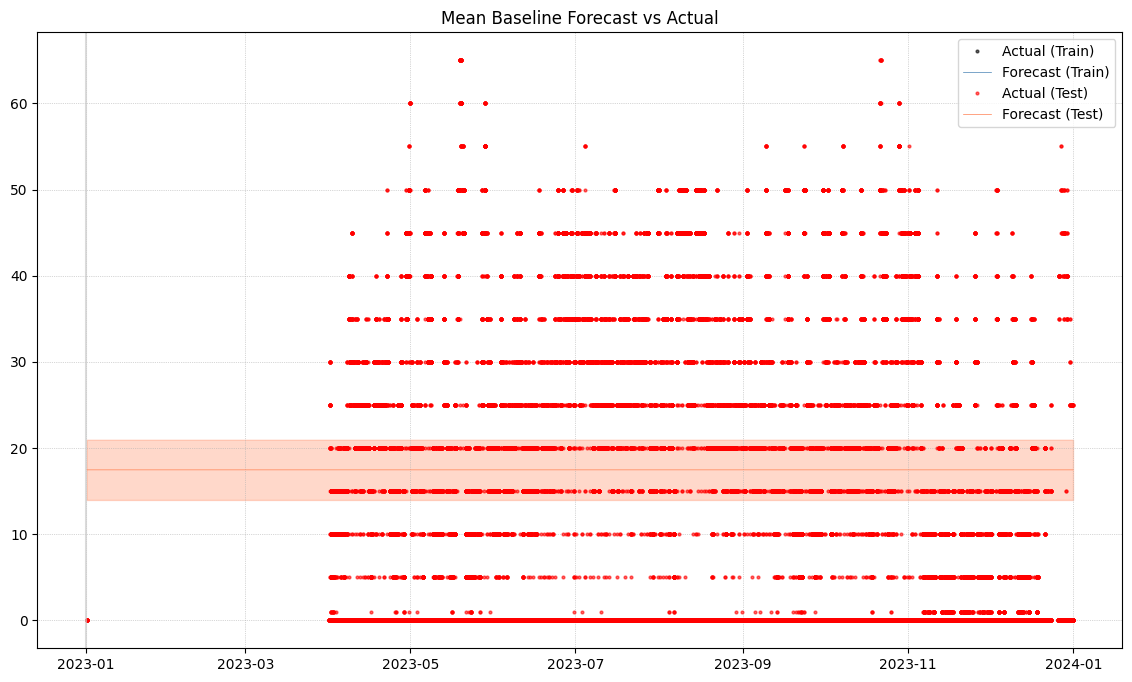

In [33]:
class MeanBaselineModel:
    """
    A simple baseline model that predicts the mean value of the training data for all future points.
    """
    def __init__(self):
        self.mean_value = None
        
    def fit(self, train_data):
        """Fit the model by calculating the mean of the training data"""
        self.mean_value = train_data['y'].mean()
        return self
        
    def predict(self, future_df):
        """Predict using the mean value for all future points"""
        predictions = pd.DataFrame({'ds': future_df['ds']})
        predictions['yhat'] = self.mean_value
        predictions['yhat_lower'] = self.mean_value * 0.8  # Simple confidence interval
        predictions['yhat_upper'] = self.mean_value * 1.2
        return predictions

print("\n---- Training Mean Baseline Model ----")
mean_model = MeanBaselineModel()
mean_model.fit(train_wait_times_filtered_df)
mean_forecast = mean_model.predict(future)
mean_verif = make_verif(mean_forecast, train_wait_times_filtered_df, val_wait_times_filtered_df)
mean_eval = evaluate_model(mean_verif, "Mean Baseline")
mean_fig = plot_verif(mean_verif, year=2023, model_name="Mean Baseline")
plt.savefig("mean_baseline_forecast.png")
print(f"Mean Baseline Evaluation: {mean_eval}")

BASELINE MODEL 2: TIME-OF-DAY BASELINE


---- Training Time-of-Day Baseline Model ----
Time-of-Day Baseline Evaluation: {'Model': 'Time-of-Day Baseline', 'RMSE': 11.959217032209985, 'MAE': 9.120774163739776, 'MAPE (%)': 14626734.747051194, 'Within CI (%)': 39.35397790740971}


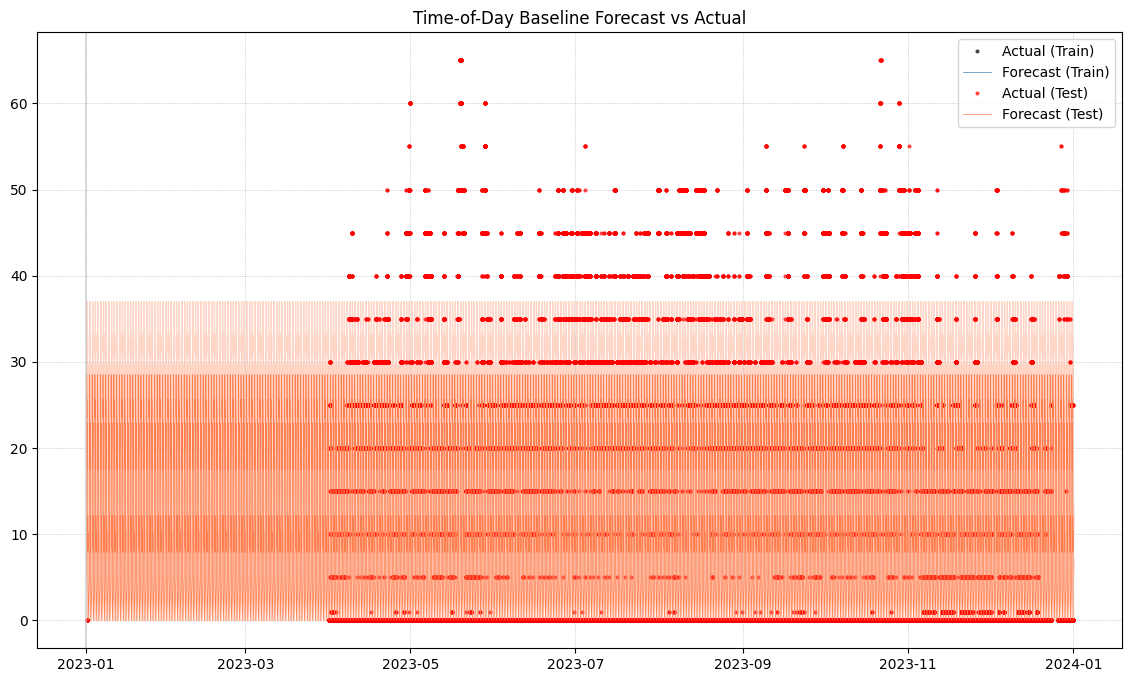

In [34]:
class TimeOfDayBaselineModel:
    """
    A baseline model that captures the daily patterns by using the average wait time 
    for each time of day based on training data.
    """
    def __init__(self):
        self.time_of_day_means = None
        
    def fit(self, train_data):
        """Fit the model by calculating mean values for each time of day"""
        # Extract hour and minute
        train_with_time = train_data.copy()
        train_with_time['hour'] = train_with_time['ds'].dt.hour
        train_with_time['minute'] = train_with_time['ds'].dt.minute
        train_with_time['time_key'] = train_with_time['hour'] * 60 + train_with_time['minute']
        
        # Calculate mean for each time of day
        self.time_of_day_means = train_with_time.groupby('time_key')['y'].mean().to_dict()
        self.global_mean = train_data['y'].mean()  # Fallback value
        
        return self
        
    def predict(self, future_df):
        """Predict using time-of-day pattern"""
        predictions = pd.DataFrame({'ds': future_df['ds']})
        
        # Extract hour and minute from prediction dates
        predictions['hour'] = predictions['ds'].dt.hour
        predictions['minute'] = predictions['ds'].dt.minute
        predictions['time_key'] = predictions['hour'] * 60 + predictions['minute']
        
        # Assign predictions based on time of day
        predictions['yhat'] = predictions['time_key'].map(
            lambda x: self.time_of_day_means.get(x, self.global_mean))
        
        # Simple confidence interval
        predictions['yhat_lower'] = predictions['yhat'] * 0.7
        predictions['yhat_upper'] = predictions['yhat'] * 1.3
        
        return predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

print("\n---- Training Time-of-Day Baseline Model ----")
tod_model = TimeOfDayBaselineModel()
tod_model.fit(train_wait_times_filtered_df)
tod_forecast = tod_model.predict(future)
tod_verif = make_verif(tod_forecast, train_wait_times_filtered_df, val_wait_times_filtered_df)
tod_eval = evaluate_model(tod_verif, "Time-of-Day Baseline")
tod_fig = plot_verif(tod_verif, year=2023, model_name="Time-of-Day Baseline")
plt.savefig("time_of_day_baseline_forecast.png")
print(f"Time-of-Day Baseline Evaluation: {tod_eval}")

BASELINE MODEL 3: DAY-OF-WEEK + TIME-OF-DAY BASELINE


---- Training Day-of-Week + Time-of-Day Baseline Model ----
Day+Time Baseline Evaluation: {'Model': 'Day+Time Baseline', 'RMSE': 11.283856978882527, 'MAE': 8.387212088234653, 'MAPE (%)': 14646359.029976066, 'Within CI (%)': 44.433411939928014}


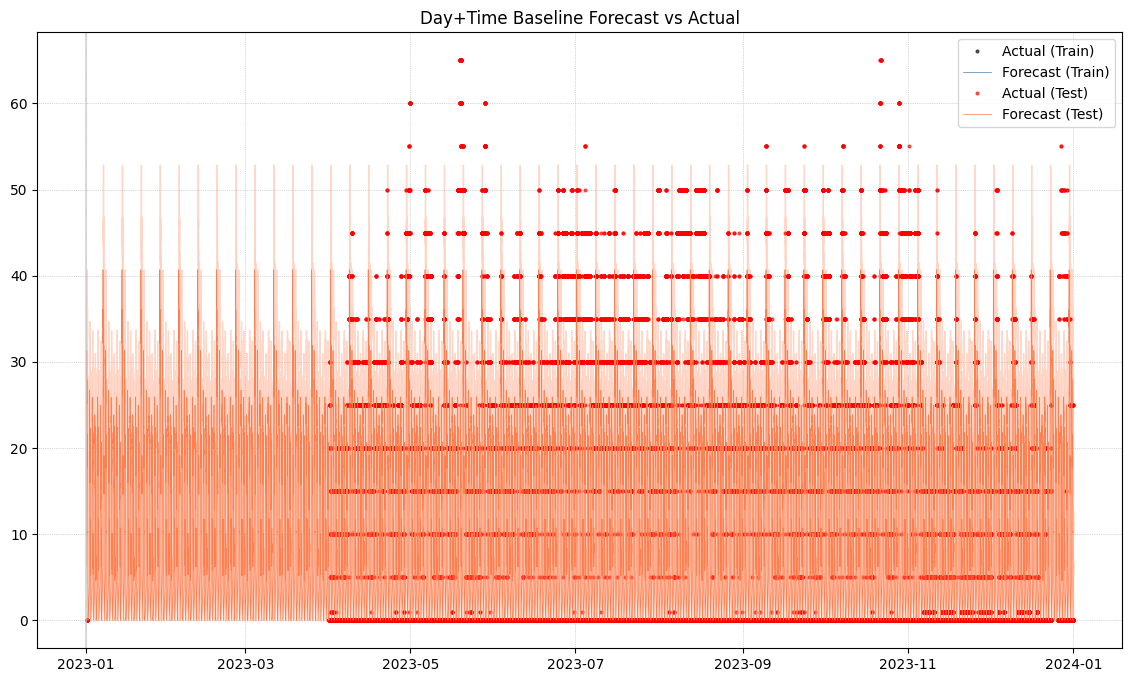

In [35]:
class DayAndTimeBaselineModel:
    """
    A model that combines day of week patterns with time of day patterns 
    for more accurate predictions.
    """
    def __init__(self):
        self.day_time_means = None
        
    def fit(self, train_data):
        """Fit the model by calculating mean values for each day of week and time of day"""
        # Extract day of week, hour and minute
        train_with_time = train_data.copy()
        train_with_time['day_of_week'] = train_with_time['ds'].dt.dayofweek
        train_with_time['hour'] = train_with_time['ds'].dt.hour
        train_with_time['minute'] = train_with_time['ds'].dt.minute
        train_with_time['time_key'] = train_with_time['hour'] * 60 + train_with_time['minute']
        train_with_time['day_time_key'] = (train_with_time['day_of_week'] * 24 * 60 + 
                                           train_with_time['time_key'])
        
        # Calculate mean for each day and time combination
        self.day_time_means = train_with_time.groupby('day_time_key')['y'].mean().to_dict()
        
        # Fallback to time of day means
        self.time_means = train_with_time.groupby('time_key')['y'].mean().to_dict()
        
        # Global mean as final fallback
        self.global_mean = train_data['y'].mean()
        
        return self
        
    def predict(self, future_df):
        """Predict using day-of-week and time-of-day patterns"""
        predictions = pd.DataFrame({'ds': future_df['ds']})
        
        # Extract day of week, hour and minute
        predictions['day_of_week'] = predictions['ds'].dt.dayofweek
        predictions['hour'] = predictions['ds'].dt.hour
        predictions['minute'] = predictions['ds'].dt.minute
        predictions['time_key'] = predictions['hour'] * 60 + predictions['minute']
        predictions['day_time_key'] = (predictions['day_of_week'] * 24 * 60 + 
                                      predictions['time_key'])
        
        # First try to find day+time combination
        predictions['yhat'] = predictions['day_time_key'].map(
            lambda x: self.day_time_means.get(x, None))
        
        # If not found, fall back to time of day
        mask = predictions['yhat'].isna()
        predictions.loc[mask, 'yhat'] = predictions.loc[mask, 'time_key'].map(
            lambda x: self.time_means.get(x, self.global_mean))
        
        # Simple confidence interval
        predictions['yhat_lower'] = predictions['yhat'] * 0.7
        predictions['yhat_upper'] = predictions['yhat'] * 1.3
        
        return predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

print("\n---- Training Day-of-Week + Time-of-Day Baseline Model ----")
day_time_model = DayAndTimeBaselineModel()
day_time_model.fit(train_wait_times_filtered_df)
day_time_forecast = day_time_model.predict(future)
day_time_verif = make_verif(day_time_forecast, train_wait_times_filtered_df, val_wait_times_filtered_df)
day_time_eval = evaluate_model(day_time_verif, "Day+Time Baseline")
day_time_fig = plot_verif(day_time_verif, year=2023, model_name="Day+Time Baseline")
plt.savefig("day_time_baseline_forecast.png")
print(f"Day+Time Baseline Evaluation: {day_time_eval}")

BASELINE MODEL 4: MOVING AVERAGE BASELINE


---- Training Moving Average Baseline Model ----
Moving Average Baseline Evaluation: {'Model': 'Moving Average Baseline', 'RMSE': 14.705564797873016, 'MAE': 11.986666134834627, 'MAPE (%)': 39181913.70201451, 'Within CI (%)': 25.425096189648755}


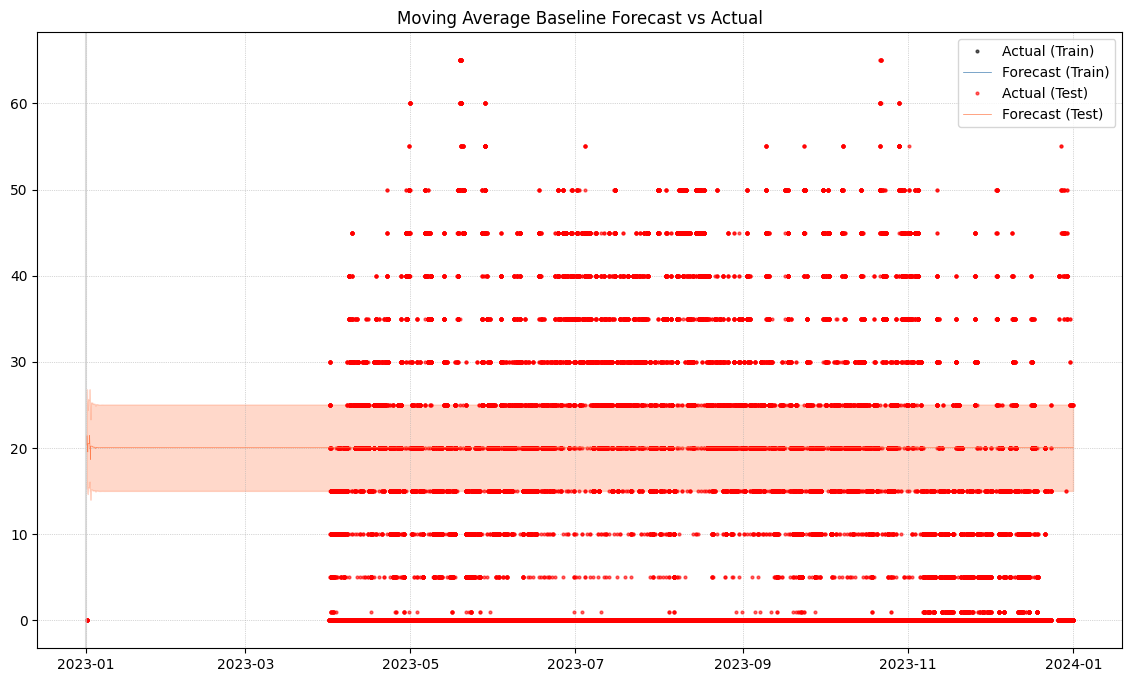

In [36]:
class MovingAverageBaselineModel:
    """
    This model uses the average of recent observations to make predictions.
    """
    def __init__(self, window_size=288):  # Default: 1 day (288 5-min intervals)
        self.window_size = window_size
        self.training_data = None
        
    def fit(self, train_data):
        """Store the training data for later prediction"""
        self.training_data = train_data.copy()
        return self
        
    def predict(self, future_df):
        """Predict using moving average of recent observations"""
        # Prepare output DataFrame
        predictions = pd.DataFrame({'ds': future_df['ds']})
        
        # Initialize with historical and future values
        full_data = pd.concat([
            self.training_data[['ds', 'y']],
            pd.DataFrame({'ds': future_df['ds'], 'y': np.nan})
        ]).sort_values('ds').reset_index(drop=True)
        
        # Calculate moving average for each prediction point
        for i in range(len(self.training_data), len(full_data)):
            # Get window of previous values
            window = full_data.loc[max(0, i-self.window_size):i-1, 'y'].dropna()
            if len(window) > 0:
                full_data.loc[i, 'y'] = window.mean()
            else:
                full_data.loc[i, 'y'] = self.training_data['y'].mean()
        
        # Extract predictions
        predictions_subset = full_data[full_data['ds'].isin(future_df['ds'])].copy()
        predictions['yhat'] = predictions_subset['y'].values
        
        # Simple confidence interval
        predictions['yhat_lower'] = predictions['yhat'] * 0.75
        predictions['yhat_upper'] = predictions['yhat'] * 1.25
        
        return predictions

print("\n---- Training Moving Average Baseline Model ----")
ma_model = MovingAverageBaselineModel(window_size=288)  # 1 day = 288 5-min intervals
ma_model.fit(train_wait_times_filtered_df)
ma_forecast = ma_model.predict(future)
ma_verif = make_verif(ma_forecast, train_wait_times_filtered_df, val_wait_times_filtered_df)
ma_eval = evaluate_model(ma_verif, "Moving Average Baseline")
ma_fig = plot_verif(ma_verif, year=2023, model_name="Moving Average Baseline")
plt.savefig("moving_average_baseline_forecast.png")
print(f"Moving Average Baseline Evaluation: {ma_eval}")

BASELINE MODEL 5: SEASONAL WEEKLY PATTERN MODEL


---- Training Seasonal Weekly Pattern Model ----
Weekly Pattern Baseline Evaluation: {'Model': 'Weekly Pattern Baseline', 'RMSE': 17.196387092600833, 'MAE': 12.893298510915491, 'MAPE (%)': 16114826.68871328, 'Within CI (%)': 64.54688241954926}


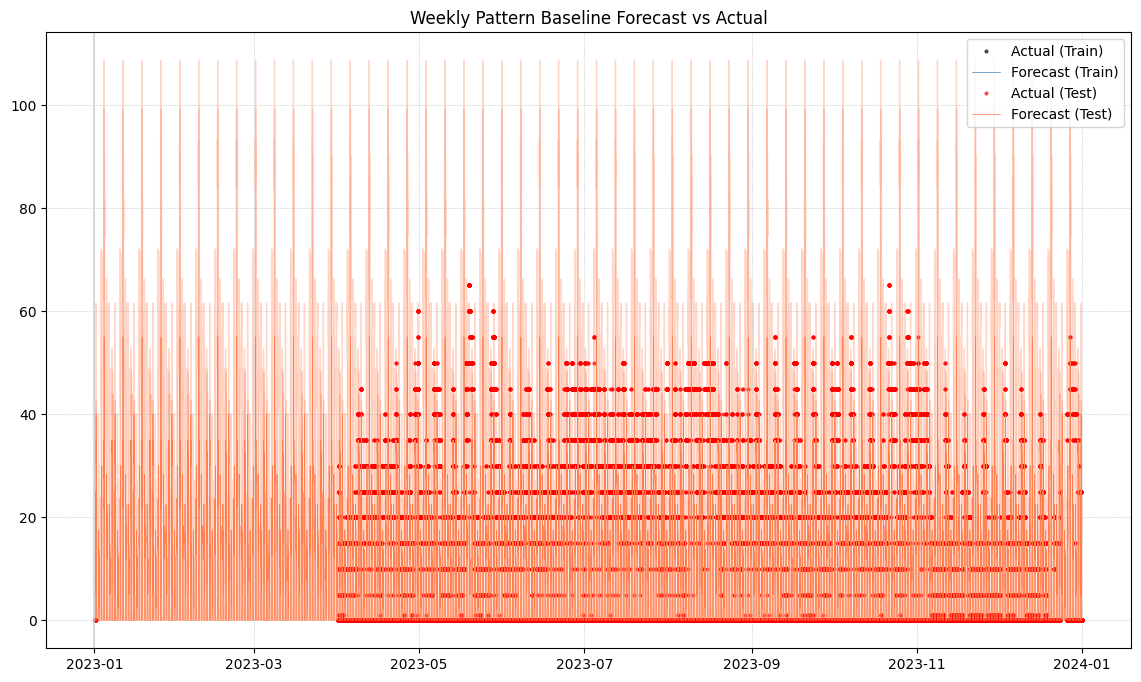

In [41]:
class SeasonalWeeklyBaselineModel:
    """
    This model leverages weekly patterns by using data from the same day and time in previous weeks.
    """
    def __init__(self, num_weeks=4):
        self.num_weeks = num_weeks
        self.training_data = None
        
    def fit(self, train_data):
        """Store the training data for later prediction"""
        # Make a copy of the training data
        self.training_data = train_data.copy()
        
        # Ensure the DataFrame has 'ds' as a column, not as an index
        if 'ds' not in self.training_data.columns:
            # If 'ds' is not in columns, check if it's in the index
            if self.training_data.index.name == 'ds':
                # If 'ds' is the index name, reset the index
                self.training_data = self.training_data.reset_index()
            elif 'ds' in self.training_data.index.names:
                # If 'ds' is part of a MultiIndex, reset just that level
                self.training_data = self.training_data.reset_index('ds')
                
        # Calculate time features
        self.training_data['day_of_week'] = self.training_data['ds'].dt.dayofweek
        self.training_data['hour'] = self.training_data['ds'].dt.hour
        self.training_data['minute'] = self.training_data['ds'].dt.minute
        self.training_data['time_key'] = self.training_data['hour'] * 60 + self.training_data['minute']
        
        # Calculate global mean for fallback
        self.global_mean = self.training_data['y'].mean()
        
        return self
        
    def predict(self, future_df):
        """Predict using the same day of week and time of day from previous weeks"""
        # Make a copy of future_df to avoid modifying the original
        future = future_df.copy()
        
        # Ensure future has 'ds' as a column
        if 'ds' not in future.columns:
            if future.index.name == 'ds':
                future = future.reset_index()
            elif 'ds' in future.index.names:
                future = future.reset_index('ds')
        
        predictions = pd.DataFrame({'ds': future['ds']})
        
        # Extract day of week and time for predictions
        predictions['day_of_week'] = predictions['ds'].dt.dayofweek
        predictions['hour'] = predictions['ds'].dt.hour
        predictions['minute'] = predictions['ds'].dt.minute
        predictions['time_key'] = predictions['hour'] * 60 + predictions['minute']
        
        # Predict for each point based on same day/time from previous weeks
        yhat = []
        yhat_lower = []
        yhat_upper = []
        
        for _, row in predictions.iterrows():
            # Find matching day and time in training data
            matches = self.training_data[
                (self.training_data['day_of_week'] == row['day_of_week']) & 
                (self.training_data['time_key'] == row['time_key'])
            ].copy()
            
            # Create a new temporary index to avoid any ambiguity with 'ds'
            matches = matches.reset_index(drop=True)
            
            # Sort by recency and take the N most recent weeks
            matches = matches.sort_values('ds', ascending=False).head(self.num_weeks)
            
            if len(matches) > 0:
                # Calculate prediction and confidence interval
                pred = matches['y'].mean()
                std = max(matches['y'].std(), 1.0)  # Prevent zero std
                yhat.append(pred)
                yhat_lower.append(max(0, pred - 1.96 * std))
                yhat_upper.append(pred + 1.96 * std)
            else:
                # Fallback to global mean if no matches
                yhat.append(self.global_mean)
                yhat_lower.append(self.global_mean * 0.7)
                yhat_upper.append(self.global_mean * 1.3)
        
        predictions['yhat'] = yhat
        predictions['yhat_lower'] = yhat_lower
        predictions['yhat_upper'] = yhat_upper
        
        return predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Add this import if not already present
import pandas as pd

# Training code remains the same
print("\n---- Training Seasonal Weekly Pattern Model ----")
weekly_model = SeasonalWeeklyBaselineModel(num_weeks=4)
weekly_model.fit(train_wait_times_filtered_df)
weekly_forecast = weekly_model.predict(future)
weekly_verif = make_verif(weekly_forecast, train_wait_times_filtered_df, val_wait_times_filtered_df)
weekly_eval = evaluate_model(weekly_verif, "Weekly Pattern Baseline")
weekly_fig = plot_verif(weekly_verif, year=2023, model_name="Weekly Pattern Baseline")
plt.savefig("weekly_pattern_baseline_forecast.png")
print(f"Weekly Pattern Baseline Evaluation: {weekly_eval}")

BASELINE MODEL 6: HOLIDAY-AWARE BASELINE


---- Training Holiday-Aware Baseline Model ----
Holiday-Aware Baseline Evaluation: {'Model': 'Holiday-Aware Baseline', 'RMSE': 11.318376524209771, 'MAE': 8.400483319324822, 'MAPE (%)': 14671564.793572491, 'Within CI (%)': 43.9710810475363}


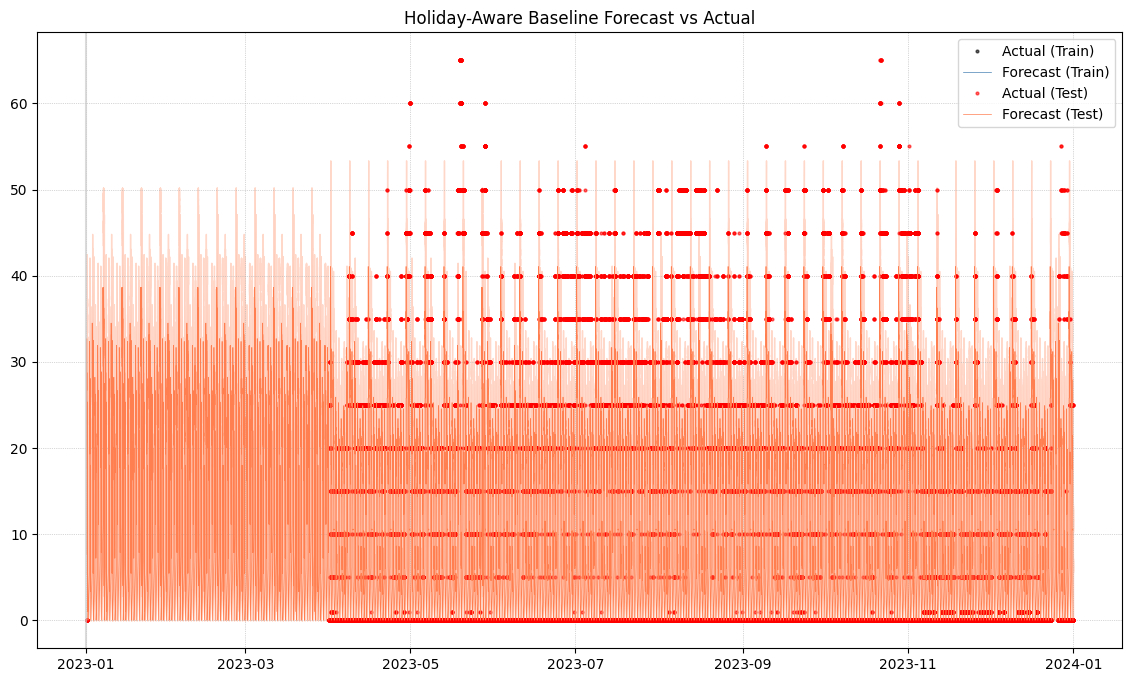

In [42]:
class HolidayAwareBaselineModel:
    """
    A model that uses different patterns for holidays and normal days
    """
    def __init__(self):
        self.holiday_day_time_means = None
        self.normal_day_time_means = None
        
    def fit(self, train_data, holiday_data):
        """
        Fit separate models for holidays and normal days
        """
        # Create a copy of training data with day and time features
        train_with_time = train_data.copy()
        train_with_time['day_of_week'] = train_with_time['ds'].dt.dayofweek
        train_with_time['hour'] = train_with_time['ds'].dt.hour
        train_with_time['minute'] = train_with_time['ds'].dt.minute
        train_with_time['time_key'] = train_with_time['hour'] * 60 + train_with_time['minute']
        train_with_time['day_time_key'] = (train_with_time['day_of_week'] * 24 * 60 + 
                                          train_with_time['time_key'])
        
        # Mark holiday days
        holiday_dates = set(holiday_data['ds'].dt.date)
        train_with_time['is_holiday'] = train_with_time['ds'].dt.date.isin(holiday_dates)
        
        # Calculate means for holiday days
        holiday_data = train_with_time[train_with_time['is_holiday']]
        self.holiday_day_time_means = holiday_data.groupby('day_time_key')['y'].mean().to_dict()
        self.holiday_time_means = holiday_data.groupby('time_key')['y'].mean().to_dict()
        
        # Calculate means for normal days
        normal_data = train_with_time[~train_with_time['is_holiday']]
        self.normal_day_time_means = normal_data.groupby('day_time_key')['y'].mean().to_dict()
        self.normal_time_means = normal_data.groupby('time_key')['y'].mean().to_dict()
        
        # Global means as fallback
        self.holiday_mean = holiday_data['y'].mean() if len(holiday_data) > 0 else train_data['y'].mean()
        self.normal_mean = normal_data['y'].mean() if len(normal_data) > 0 else train_data['y'].mean()
        self.global_mean = train_data['y'].mean()
        
        return self
        
    def predict(self, future_df, holiday_data):
        """
        Predict using different models for holidays and normal days
        """
        predictions = pd.DataFrame({'ds': future_df['ds']})
        
        # Extract day and time features
        predictions['day_of_week'] = predictions['ds'].dt.dayofweek
        predictions['hour'] = predictions['ds'].dt.hour
        predictions['minute'] = predictions['ds'].dt.minute
        predictions['time_key'] = predictions['hour'] * 60 + predictions['minute']
        predictions['day_time_key'] = (predictions['day_of_week'] * 24 * 60 + 
                                      predictions['time_key'])
        
        # Mark holiday days
        holiday_dates = set(holiday_data['ds'].dt.date)
        predictions['is_holiday'] = predictions['ds'].dt.date.isin(holiday_dates)
        
        # Initialize predictions
        predictions['yhat'] = np.nan
        
        # Predict for holiday days
        holiday_mask = predictions['is_holiday']
        
        # First try day+time for holidays
        predictions.loc[holiday_mask, 'yhat'] = predictions.loc[holiday_mask, 'day_time_key'].map(
            lambda x: self.holiday_day_time_means.get(x, None))
        
        # Fall back to time of day for holidays
        still_na = holiday_mask & predictions['yhat'].isna()
        predictions.loc[still_na, 'yhat'] = predictions.loc[still_na, 'time_key'].map(
            lambda x: self.holiday_time_means.get(x, self.holiday_mean))
        
        # Predict for normal days
        normal_mask = ~predictions['is_holiday']
        
        # First try day+time for normal days
        predictions.loc[normal_mask, 'yhat'] = predictions.loc[normal_mask, 'day_time_key'].map(
            lambda x: self.normal_day_time_means.get(x, None))
        
        # Fall back to time of day for normal days
        still_na = normal_mask & predictions['yhat'].isna()
        predictions.loc[still_na, 'yhat'] = predictions.loc[still_na, 'time_key'].map(
            lambda x: self.normal_time_means.get(x, self.normal_mean))
        
        # Final fallback to global mean
        still_na = predictions['yhat'].isna()
        predictions.loc[still_na, 'yhat'] = self.global_mean
        
        # Simple confidence interval
        predictions['yhat_lower'] = predictions['yhat'] * 0.7
        predictions['yhat_upper'] = predictions['yhat'] * 1.3
        
        return predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

print("\n---- Training Holiday-Aware Baseline Model ----")
holiday_model = HolidayAwareBaselineModel()
holiday_model.fit(train_wait_times_filtered_df, all_holidays_df)
holiday_forecast = holiday_model.predict(future, all_holidays_df)
holiday_verif = make_verif(holiday_forecast, train_wait_times_filtered_df, val_wait_times_filtered_df)
holiday_eval = evaluate_model(holiday_verif, "Holiday-Aware Baseline")
holiday_fig = plot_verif(holiday_verif, year=2023, model_name="Holiday-Aware Baseline")
plt.savefig("holiday_aware_baseline_forecast.png")
print(f"Holiday-Aware Baseline Evaluation: {holiday_eval}")


Collect all evaluation results

In [43]:
all_evaluations = [
    mean_eval,
    tod_eval,
    day_time_eval,
    ma_eval,
    weekly_eval,
    holiday_eval
]

Create evaluation dataframe

In [44]:
eval_df = pd.DataFrame(all_evaluations)
eval_df = eval_df.sort_values('RMSE')
print("\n---- All Model Evaluations ----")
print(eval_df)


---- All Model Evaluations ----
                     Model       RMSE        MAE      MAPE (%)  Within CI (%)
2        Day+Time Baseline  11.283857   8.387212  1.464636e+07      44.433412
5   Holiday-Aware Baseline  11.318377   8.400483  1.467156e+07      43.971081
1     Time-of-Day Baseline  11.959217   9.120774  1.462673e+07      39.353978
3  Moving Average Baseline  14.705565  11.986666  3.918191e+07      25.425096
0            Mean Baseline  14.729116  12.062282  3.415779e+07      27.466799
4  Weekly Pattern Baseline  17.196387  12.893299  1.611483e+07      64.546882


Comparative plot for 1 week sample

In [45]:
plt.figure(figsize=(16, 8))

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

Select sample period (e.g., 1 week in April 2023)

In [46]:
sample_start = '2023-04-01'
sample_end = '2023-04-07'

Plot each model

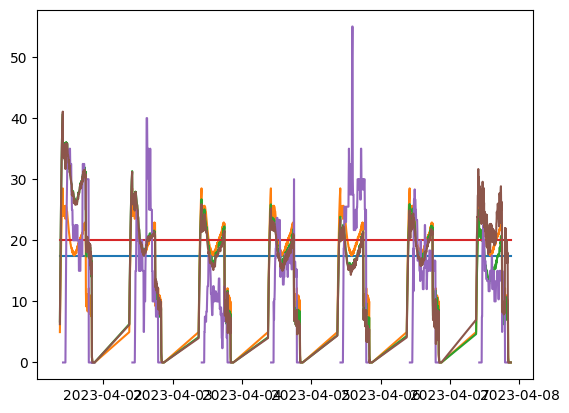

In [47]:
plt.plot(mean_verif.loc[sample_start:sample_end].index, mean_verif.loc[sample_start:sample_end].yhat, 
         label='Mean Baseline', linewidth=1.5)
plt.plot(tod_verif.loc[sample_start:sample_end].index, tod_verif.loc[sample_start:sample_end].yhat, 
         label='Time-of-Day Baseline', linewidth=1.5)
plt.plot(day_time_verif.loc[sample_start:sample_end].index, day_time_verif.loc[sample_start:sample_end].yhat, 
         label='Day+Time Baseline', linewidth=1.5)
plt.plot(ma_verif.loc[sample_start:sample_end].index, ma_verif.loc[sample_start:sample_end].yhat, 
         label='Moving Average Baseline', linewidth=1.5)
plt.plot(weekly_verif.loc[sample_start:sample_end].index, weekly_verif.loc[sample_start:sample_end].yhat, 
         label='Weekly Pattern Baseline', linewidth=1.5)
plt.plot(holiday_verif.loc[sample_start:sample_end].index, holiday_verif.loc[sample_start:sample_end].yhat, 
         label='Holiday-Aware Baseline', linewidth=1.5)

Plot actual values

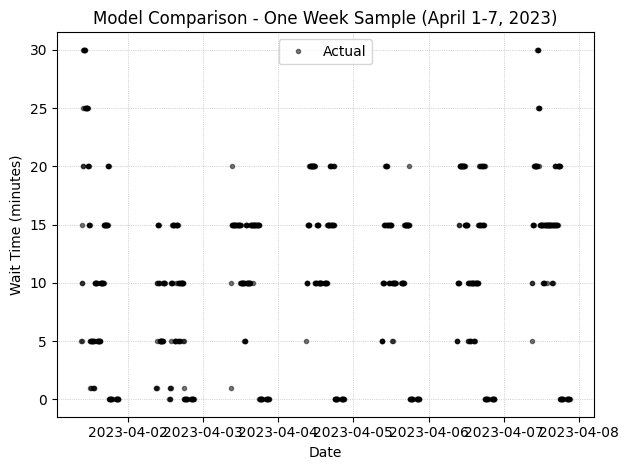

In [48]:
plt.plot(mean_verif.loc[sample_start:sample_end].index, mean_verif.loc[sample_start:sample_end].y, 
         'k.', alpha=0.5, label='Actual')

plt.title('Model Comparison - One Week Sample (April 1-7, 2023)')
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
plt.legend()
plt.grid(ls=':', lw=0.5)
plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()